In [1]:
import sys

sys.path.append("/app")
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from src.climate_learn.utils.gis import (
    prepare_ynet_climatology,
    prepare_deepsd_elevation,
)

from src.climate_learn.models.module import (
    DeepSDLitModule,
    DiffusionLitModule,
    LitModule,
    YnetLitModule,
    DeepSDLitModule,
)
import torch
from torchvision import transforms

In [2]:
dm = IterDataModule(
    task="downscaling",
    inp_root_dir="/app/data/processed/cmip6-era5/cmip6/D",
    out_root_dir="/app/data/processed/cmip6-era5/era5_0.25/D",
    in_vars=["air_temperature", "u_component_of_wind", "v_component_of_wind", "precipitation", "pressure_sea_level", "orography", "land_sea_mask", "latitude", "specific_humidity", "cloud_cover", "upward_heat_flux", "moisture_in_soil"],
    out_vars=["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "total_precipitation"],
    subsample=1,
    batch_size=1,
    num_workers=4,
)
dm.setup()

In [3]:
# Retrieve the shape of the 2m temperature data from the first item in the test dataset
temperature_shape = next(iter(dm.data_test.dataset.dataset))[1]["2m_temperature"].shape
print(f"Shape of 2m temperature data: {temperature_shape}")

# Get the shape of the first batch of data from the test dataloader
first_batch_shape = next(iter(dm.test_dataloader()))[0].shape
print(f"Shape of the first batch from test dataloader: {first_batch_shape}")

in_vars, out_vars = dm.get_data_variables()
in_shape, out_shape = dm.get_data_dims()
in_channels, in_height, in_width = in_shape[1:]
out_channels, out_height, out_width = out_shape[1:]

# Printing detailed information about input and output shapes for clarity
print(
    f"Input Channels = {in_channels}, Input Height = {in_height}, Input Width = {in_width}"
)
print(
    f"Output Channels = {out_channels}, Output Height = {out_height}, Output Width = {out_width}"
)

Shape of 2m temperature data: (73, 720, 1440)
Shape of the first batch from test dataloader: torch.Size([1, 12, 180, 360])
Input Channels = 12, Input Height = 180, Input Width = 360
Output Channels = 4, Output Height = 720, Output Width = 1440


In [4]:
unet = load_downscaling_module(data_module=dm, architecture="unet")
# samvit = load_downscaling_module(data_module=dm, architecture="samvit")
ynet = load_downscaling_module(data_module=dm, architecture="ynet", upsampling=None)
deepsd = load_downscaling_module(data_module=dm, architecture="deepsd", upsampling=None)
# diffusion = load_downscaling_module(data_module=dm, architecture="diffusion", upsampling=None)

In [5]:
unet = LitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-CMIP-ERA-D/unet_multi_bilinear_777/logs/version_3/checkpoints/epoch_005.ckpt",
            net=unet.net,
            optimizer=unet.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=unet.test_loss,
            test_target_transforms=unet.test_target_transforms,)
normalized_clim = prepare_ynet_climatology(dm, "/app/data/elevation.nc", out_vars)
ynet = YnetLitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-CMIP-ERA-D/ynet_multi_none_777/logs/version_0/checkpoints/epoch_043.ckpt",
            net=ynet.net,
            optimizer=ynet.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=ynet.test_loss,
            test_target_transforms=ynet.test_target_transforms,
            normalized_clim=normalized_clim)
elevation_list = prepare_deepsd_elevation(dm, path_to_elevation="/app/data/elevation.nc")
deepsd = DeepSDLitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_0/checkpoints/epoch_040.ckpt",
            net=deepsd.net,
            optimizer=deepsd.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=deepsd.test_loss,
            test_target_transforms=deepsd.test_target_transforms,
            elevation=elevation_list)

In [6]:
dm.get_out_transforms()

{'2m_temperature': Normalize(mean=278.13616943359375, std=21.356901168823242),
 '10m_u_component_of_wind': Normalize(mean=-0.05281675234436989, std=5.157989978790283),
 '10m_v_component_of_wind': Normalize(mean=0.18568924069404602, std=4.24746036529541),
 'total_precipitation': Normalize(mean=0.09873960167169571, std=0.23127733170986176)}

0it [00:03, ?it/s]


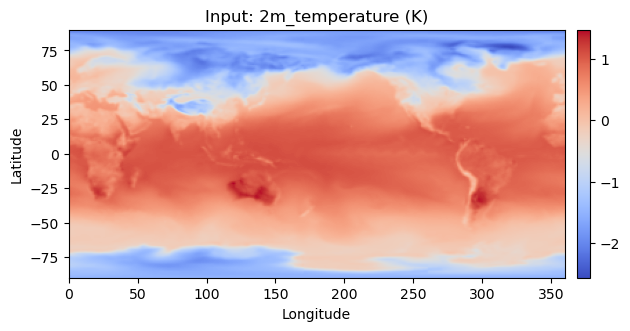

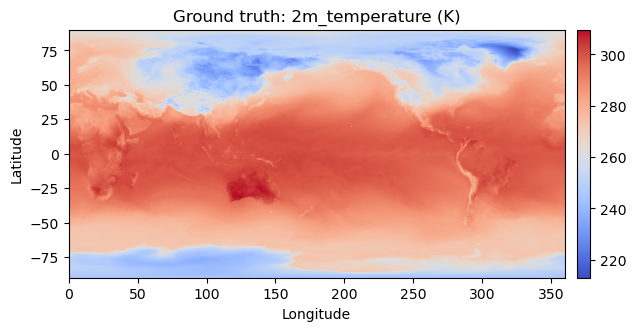

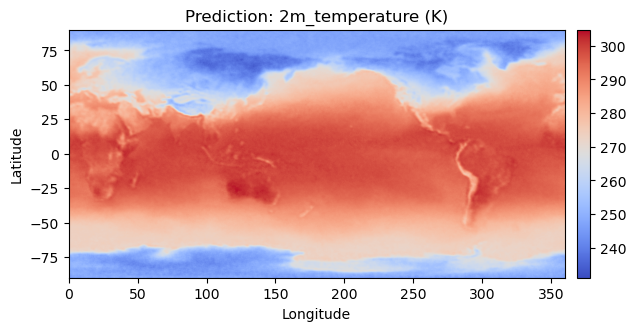

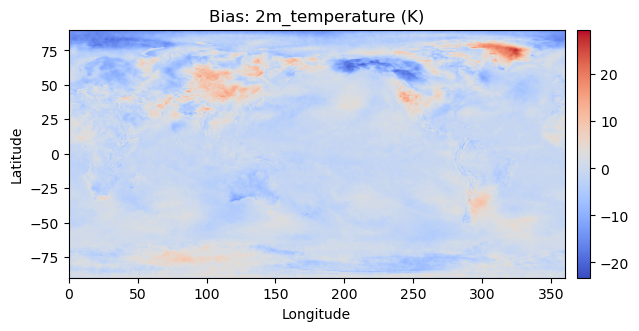

In [11]:
denorm = unet.test_target_transforms[0]
in_graphic = visualize_at_index(
    unet.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:03, ?it/s]


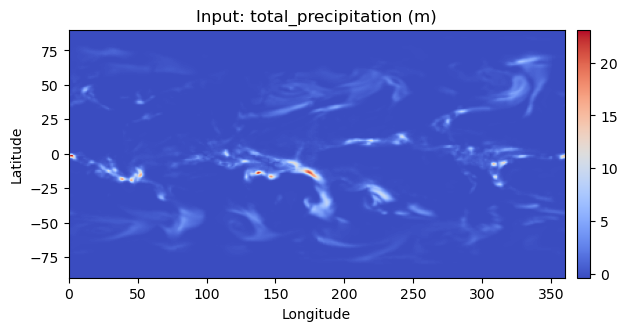

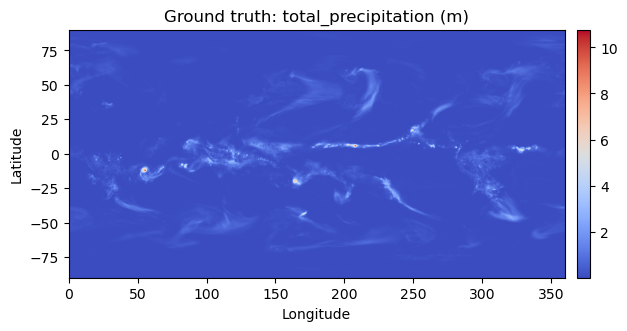

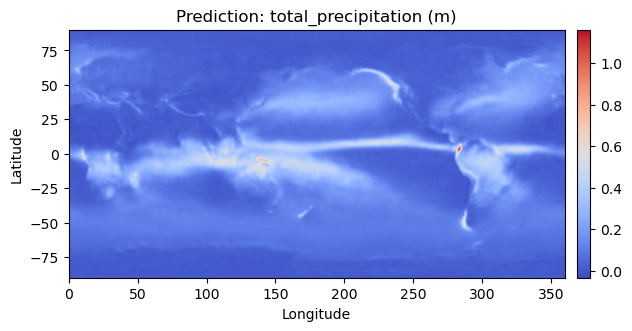

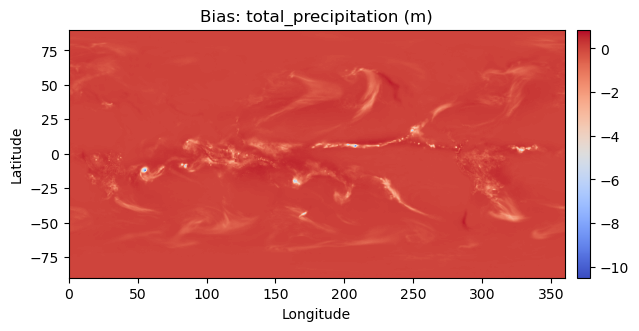

In [13]:
in_graphic = visualize_at_index(
    unet.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    variable="total_precipitation",
    src="era5",
    index=0,
)

0it [00:02, ?it/s]


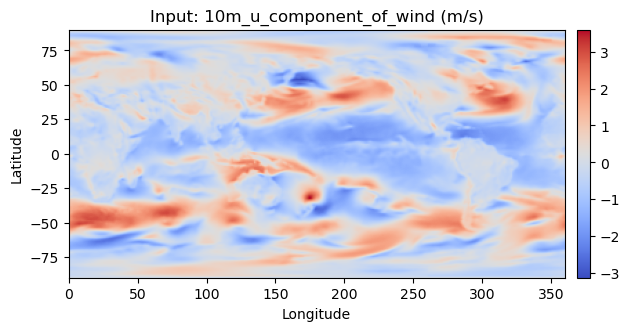

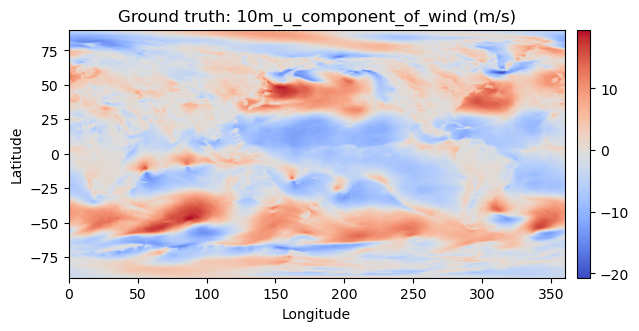

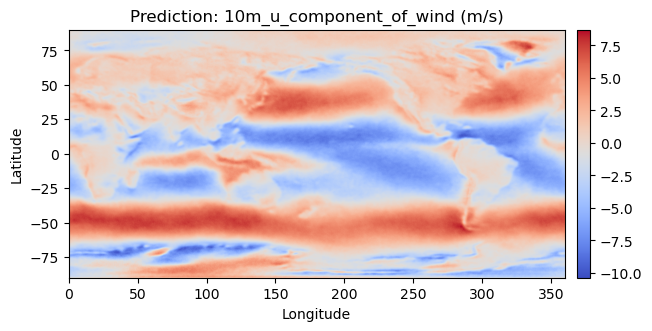

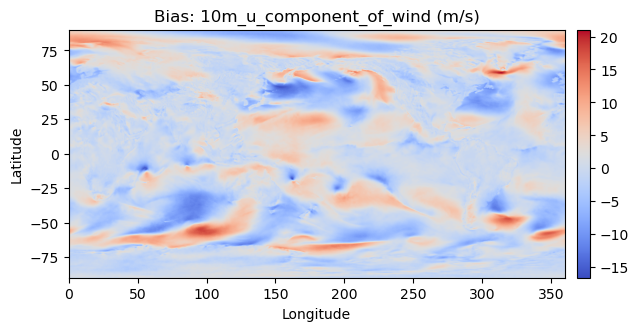

In [14]:
in_graphic = visualize_at_index(
    unet.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    variable="10m_u_component_of_wind",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]

/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
0it [00:03, ?it/s]


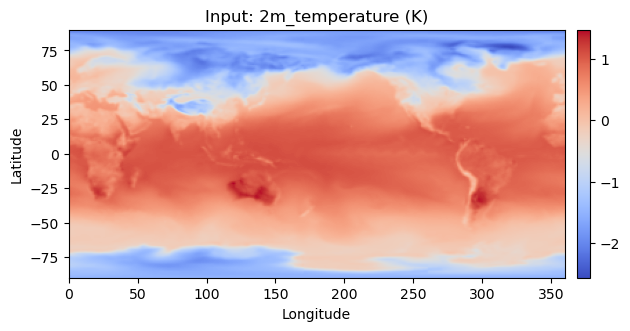

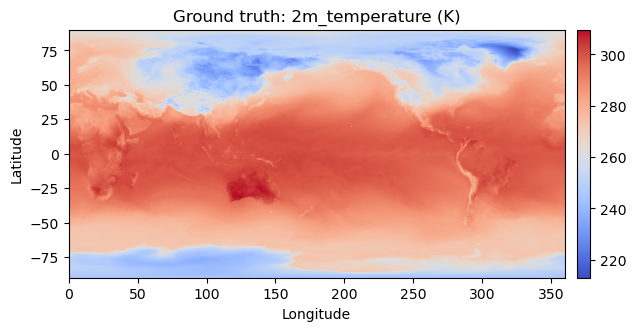

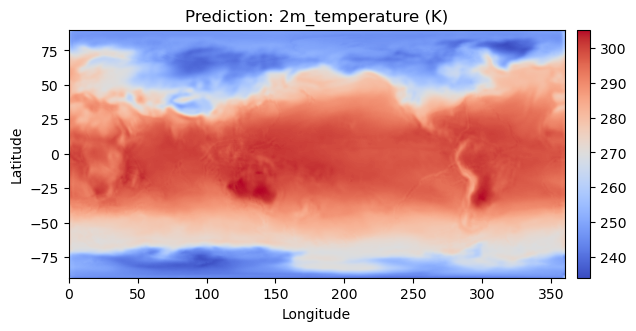

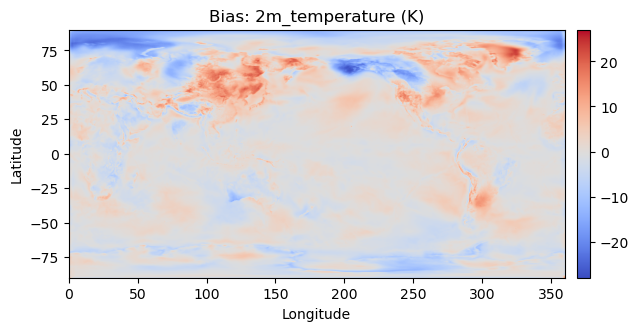

In [15]:
in_graphic = visualize_at_index(
    deepsd.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:02, ?it/s]


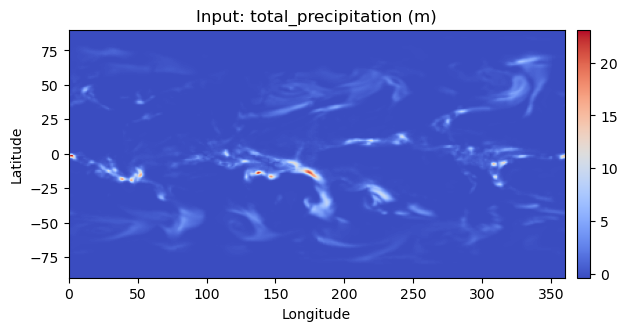

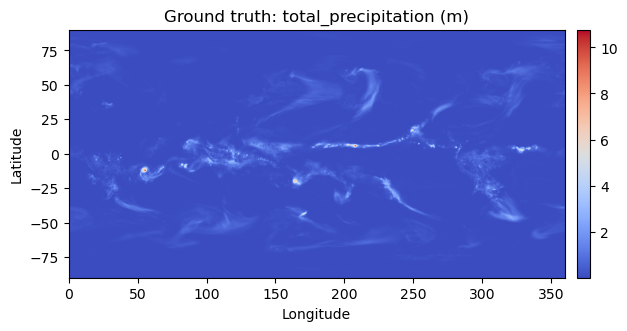

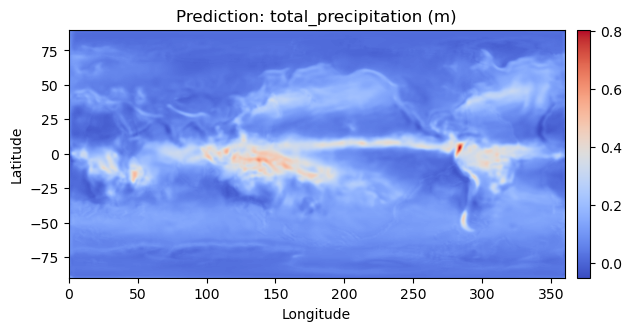

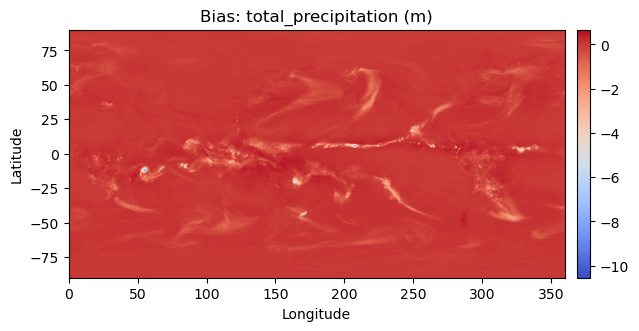

In [16]:
in_graphic = visualize_at_index(
    deepsd.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    variable="total_precipitation",
    src="era5",
    index=0,
)

0it [00:02, ?it/s]


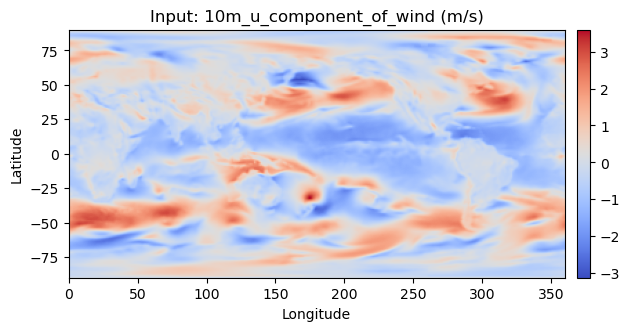

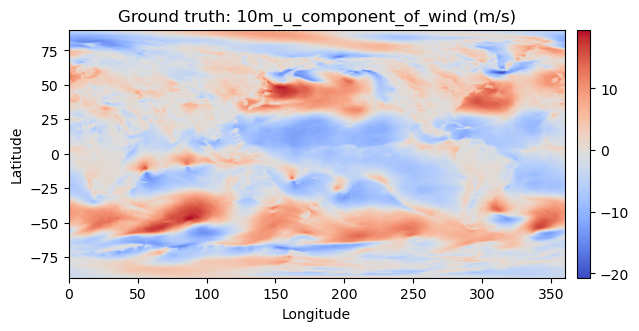

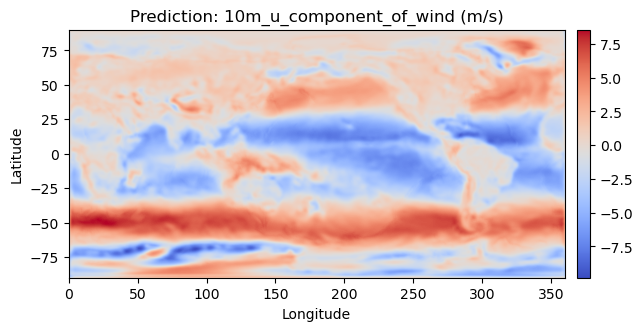

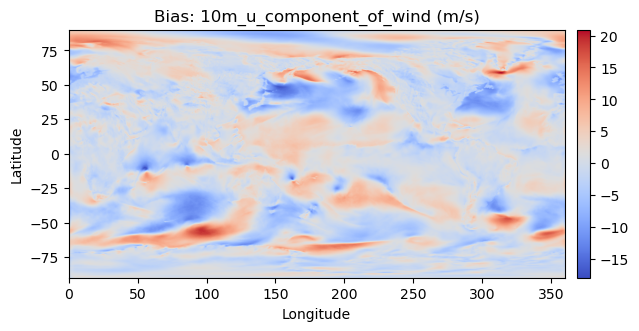

In [17]:
in_graphic = visualize_at_index(
    deepsd.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    variable="10m_u_component_of_wind",
    src="era5",
    index=0,
)